<a href="https://colab.research.google.com/github/VissROMs/Roms_Waves/blob/master/RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/Alcohol_Sales.csv", index_col=0, parse_dates=True)

In [ ]:
df.columns = ["Sales"]

<Axes: xlabel='DATE'>

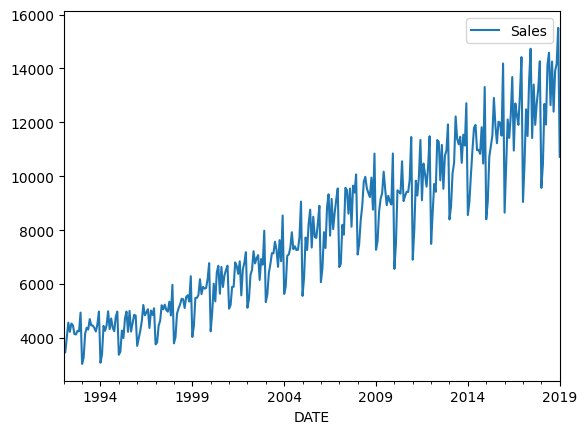

In [ ]:
df.plot()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df["Sales"])

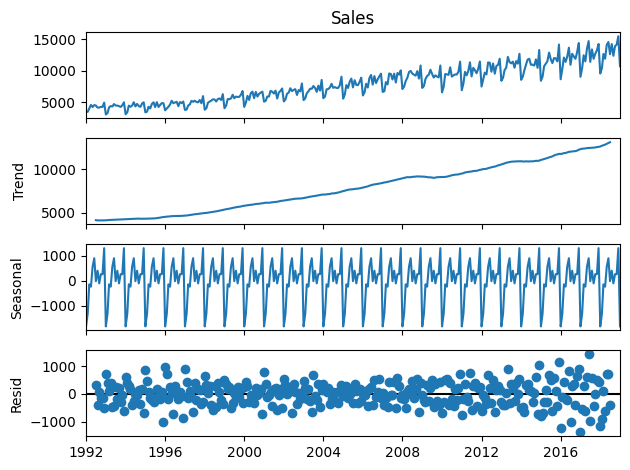

In [ ]:
results.plot();

<Axes: xlabel='DATE'>

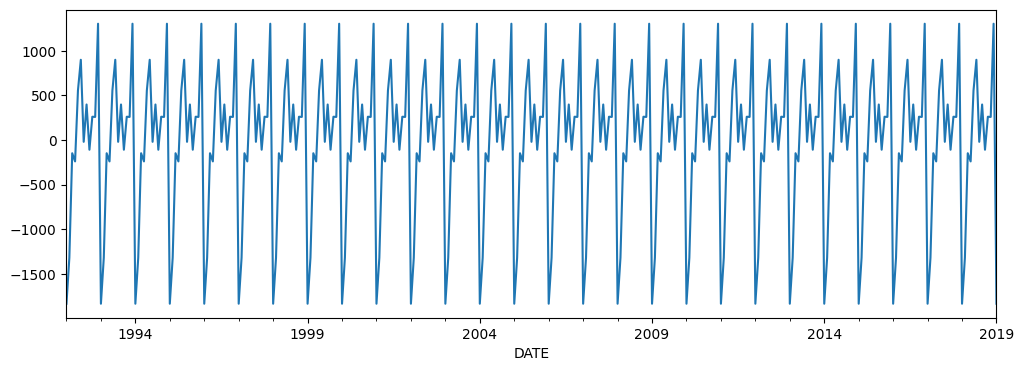

In [ ]:
results.seasonal.plot(figsize=(12,4))

In [ ]:
len(df)

325

In [ ]:
train = df.iloc[:313]
test = df.iloc[313:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
n = MinMaxScaler()
n.fit(train)
scaled_train = n.transform(train)
scaled_test = n.transform(test)

In [ ]:
#[t1, t2, t3, t4] -----> [t5]

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
n_input=12
n_features=1
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=n_features)

In [ ]:
x, y = train_generator[0]
x, y

(array([[[0.03658432],
         [0.03649885],
         [0.08299855],
         [0.13103684],
         [0.1017181 ],
         [0.12804513],
         [0.12266006],
         [0.09453799],
         [0.09359774],
         [0.10496624],
         [0.10334217],
         [0.16283443]]]),
 array([[0.]]))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf

In [ ]:
model = Sequential([
    LSTM(150, activation="relu", input_shape=(n_input, n_features)),
    Dense(1)
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 150)               91200     
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91351 (356.84 KB)
Trainable params: 91351 (356.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
hist=model.fit_generator(train_generator, epochs=25, verbose=0)

<ipython-input-48-8ec01a27afff>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=model.fit_generator(train_generator, epochs=25, verbose=0)


In [ ]:
print(hist.history.keys())

dict_keys(['loss'])


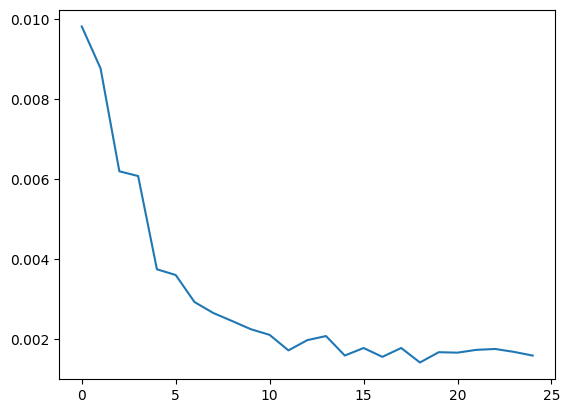

In [ ]:
plt.plot(range(len(hist.history["loss"])),hist.history["loss"])

In [ ]:
# 12 history steps ----> Predict 13 step
# We need 12 last points of train data to predict the first one to test data

In [ ]:
first_evaluation_batch = scaled_train[-12:]
first_evaluation_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [ ]:
first_evaluation_batch = np.reshape(first_evaluation_batch,(1,12,1))

In [ ]:
model.predict(first_evaluation_batch)

1/1 [==============================] - 0s 283ms/step


array([[0.6844182]], dtype=float32)

In [ ]:
##### SOS -----> Forecast using this LSTM Model

In [ ]:
test_predictions = [] # Holder of Predictions
first_evaluation_batch = scaled_train[-n_input:]
current_batch = np.reshape(first_evaluation_batch, (1,12,1))
for i in range(len(scaled_test)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 26ms/step


In [ ]:
true_predictions = n.inverse_transform(test_predictions)


In [ ]:
test

,Sales
DATE,
2018-02-01,10415
2018-03-01,12683
2018-04-01,11919
2018-05-01,14138
2018-06-01,14583
2018-07-01,12640
2018-08-01,14257
2018-09-01,12396
2018-10-01,13914


In [ ]:
test["predictions"] = true_predictions

<ipython-input-67-07ec526ac01a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions"] = true_predictions


<Axes: xlabel='DATE'>

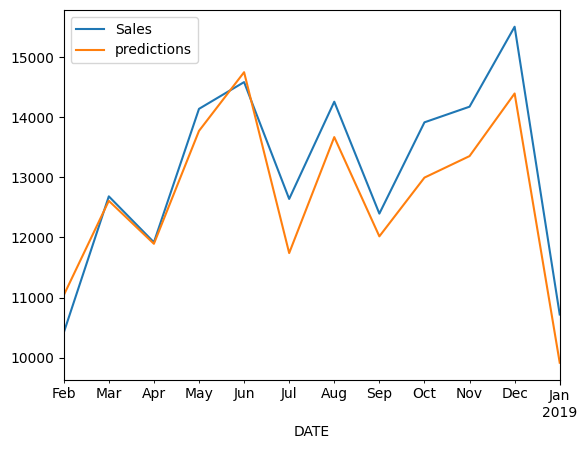

In [ ]:
test.plot()

In [ ]:
model.save("mymodel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
pwd

'/content'

In [ ]:
from keras.models import load_model
new_model = load_model("mymodel.h5")